# Goals

This notebook will map pout the burr pipelines that we will use to do document ingestion

## ENV Variables

In [1]:
# set your OpenAI API key
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Verify that the API key is loaded
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')

# Ingestion Flow DAG  

The Ingestion covers adding new files to the sql lite database.


At this level we will include:
- monitor: find new files
- validation: they are unique with a has
- ingest: move to raw stortage
- index: add to database


In [14]:
import importlib
from ragnostic import ingestion
importlib.reload(ingestion)

state = ingestion.run_ingestion(
    ingest_dir="./+ingest",
    # kwargs
    storage_dir = "./+storage",
    db_path = "./+ragnostic_db.db",
    max_file_size = 100 * 1024 * 1024,  # 100MB
    text_preview_chars = 1000
)
state

Processing +storage/DOC_m2rwnctechtu.pdf...
]========================================] (4/4)
Processing +storage/DOC_7kkl8igzpp1l.pdf...
]========================================] (6/6)


{'__SEQUENCE_ID': 3, 'monitor_result': MonitorResult(status=<MonitorStatus.MONITORING: 'monitoring'>, files=[PosixPath('/home/nicholasgrundl/projects/ragnostic/notebooks/+ingest/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf'), PosixPath('/home/nicholasgrundl/projects/ragnostic/notebooks/+ingest/JOURNAL_2017_AerationCostsInStirredTankAndBubbleColumnBioreactors.pdf')], error_message=None), 'error': None, '__PRIOR_STEP': 'indexing', 'validation_result': BatchValidationResult(valid_files=[ValidationResult(filepath=PosixPath('/home/nicholasgrundl/projects/ragnostic/notebooks/+ingest/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf'), is_valid=True, file_hash='48b3eab939120f59e570fded9292438fbca130cbc7055f78311e3c2498a256c7', mime_type='application/pdf', file_size_bytes=115486, check_failures=[]), ValidationResult(filepath=PosixPath('/home/nicholasgrundl/projects/ragnostic/notebooks/+ingest/JOURNAL_2017_AerationCostsInStirredTankAndBubbleColumnBioreactors.pdf'), is_v

# Look in database

In [10]:
from ragnostic import db
db_path = '+ragnostic_db.db'
db_url = db.create_sqlite_url(db_path)
db_client = db.DatabaseClient(db_url)

In [11]:
documents = db_client.get_documents()
for document in documents:
    doc_id = document.id
    print(f"- filepath: {document.raw_file_path}")
    metadata = db_client.get_metadata(doc_id=doc_id)
    print(f"- metadata:")
    print(metadata.model_dump_json(indent=4))

- filepath: storage/DOC_jfofei515yhm.pdf
- metadata:
{
    "doc_id": "DOC_jfofei515yhm",
    "title": "New Title",
    "authors": null,
    "creation_date": "2025-02-03T11:31:18.233661",
    "page_count": 4,
    "language": null
}
- filepath: storage/DOC_qqp37311ygrz.pdf
- metadata:
{
    "doc_id": "DOC_qqp37311ygrz",
    "title": "Aeration Costs in Stirred-Tank and Bubble Column Bioreactors",
    "authors": [
        "D. Humbird",
        "R. Davis",
        "J.D. McMillan"
    ],
    "creation_date": "2025-02-03T11:31:19.194785",
    "page_count": 6,
    "language": null
}


# Step one by one

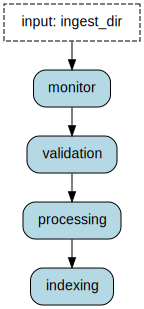

In [4]:
pipeline = ingestion.build_ingestion_workflow(
    storage_dir = "./+storage",
    db_path = "./+ragnostic_db.db",
    max_file_size = 100 * 1024 * 1024,  # 100MB
    text_preview_chars = 1000
)
pipeline

In [23]:
# Run time parameters
ingest_dir = "./+ingest"

# Run step by step
*_, state = pipeline.run(halt_after=["monitor"], inputs={"ingest_dir": ingest_dir})
display(list(state.keys()))
state['monitor_result']

['__SEQUENCE_ID', 'monitor_result', 'error', '__PRIOR_STEP']

MonitorResult(status=<MonitorStatus.MONITORING: 'monitoring'>, files=[PosixPath('/home/nicholasgrundl/projects/ragnostic/notebooks/ingest/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf'), PosixPath('/home/nicholasgrundl/projects/ragnostic/notebooks/ingest/JOURNAL_2017_AerationCostsInStirredTankAndBubbleColumnBioreactors.pdf')], error_message=None)

In [24]:
# Run step by step
*_, state = pipeline.run(halt_after=["validation"])
display(list(state.keys()))
state['validation_result']

['__SEQUENCE_ID',
 'monitor_result',
 'error',
 '__PRIOR_STEP',
 'validation_result']

BatchValidationResult(valid_files=[ValidationResult(filepath=PosixPath('/home/nicholasgrundl/projects/ragnostic/notebooks/ingest/JOURNAL_2017_AerationCostsInStirredTankAndBubbleColumnBioreactors.pdf'), is_valid=True, file_hash='f143e12292f0b459cd8759b41e52756d4fcf64cc9014ced662e177f196288b4a', mime_type='application/pdf', file_size_bytes=1443939, check_failures=[])], invalid_files=[ValidationResult(filepath=PosixPath('/home/nicholasgrundl/projects/ragnostic/notebooks/ingest/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf'), is_valid=False, file_hash=None, mime_type=None, file_size_bytes=None, check_failures=[ValidationCheckFailure(filepath=PosixPath('/home/nicholasgrundl/projects/ragnostic/notebooks/ingest/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf'), check_type=<ValidationCheckType.DUPLICATE_HASH: 'duplicate_hash'>, message='Document with same hash already exists', details={'existing_doc_id': 'DOC_jx8vvul2fv35'})])])

In [25]:
# Run step by step
*_, state = pipeline.run(halt_after=["processing"])
display(list(state.keys()))
state['processing_result']

['__SEQUENCE_ID',
 'monitor_result',
 'error',
 '__PRIOR_STEP',
 'validation_result',
 'processing_result']

BatchProcessingResult(successful_docs=[ProcessingResult(doc_id='DOC_4v6yzjjovrv0', original_path=PosixPath('/home/nicholasgrundl/projects/ragnostic/notebooks/ingest/JOURNAL_2017_AerationCostsInStirredTankAndBubbleColumnBioreactors.pdf'), storage_path=PosixPath('storage/DOC_4v6yzjjovrv0.pdf'), status=<ProcessingStatus.SUCCESS: 'success'>, error_message=None, error_code=None)], failed_docs=[])

In [26]:
# Run step by step
*_, state = pipeline.run(halt_after=["indexing"])
display(list(state.keys()))
state['indexing_result']

Processing storage/DOC_4v6yzjjovrv0.pdf...
]========================================] (6/6)


['__SEQUENCE_ID',
 'monitor_result',
 'error',
 '__PRIOR_STEP',
 'validation_result',
 'processing_result',
 'indexing_result']

BatchIndexingResult(successful_docs=[IndexingResult(doc_id='DOC_4v6yzjjovrv0', filepath=PosixPath('storage/DOC_4v6yzjjovrv0.pdf'), status=<IndexingStatus.SUCCESS: 'success'>, error_message=None, extracted_metadata=DocumentMetadataExtracted(title='Aeration Costs in Stirred-Tank and Bubble Column Bioreactors', authors=['D. Humbird', 'R. Davis', 'J.D. McMillan'], creation_date=datetime.datetime(2025, 2, 3, 11, 18, 50, 251743), page_count=6, language=None, text_preview='Contents lists available at ScienceDirect\n\n# Biochemical Engineering Journal\n\njournal homepage: www.elsevier.com\n\n\n#### Regular article\n\n## Aeration costs in stirred-tank and bubble column bioreactors\n\n### D. Humbird[a], R. Davis[b,][ ⁎], J.D. McMillan[b]\n\na DWH Process Consulting LLC, Centennial, CO, United States\nb National Renewable Energy Laboratory, National Bioenergy Center, Golden, CO, United States\n\n\nA R T I C L E I N F O\n\n_Article history:_\nReceived 21 February 2017\nReceived in revised form 24 

# Processing Flow DAG

The Processing covers metadata and document text content to the database.

At this level we will include:
- document_router: send to PDF or website processer
- text_extraction: extract text from pdf
- image_extraction: extract images and store in database
- table_extraction: extract tables and store in database
- metadata_extraction: update metadata


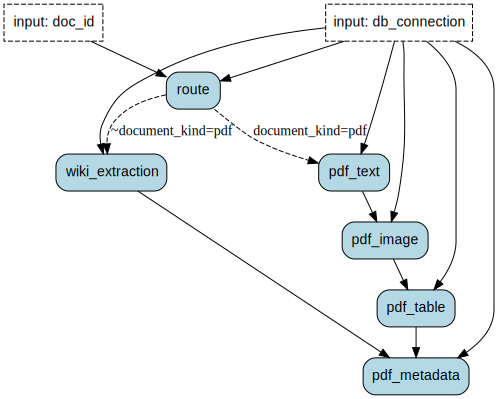

In [13]:
import pathlib
from burr.core import State, action, ApplicationBuilder
from burr.core import when

from ragnostic import utils

@action(reads=[], writes=["document_kind"])
def document_router(state: State, doc_id: str, db_connection) -> State:
    """Determine how to process the doc"""

    # Determine how to process the doc id based on the library entry
    # - Is it a PDF or a HTML?
    # - has it already been processed before?

    #Design Choices:
    # - should we load the document here or later?
    # - if loaded should we store it in the state as a python object?
    return state.update(document_kind='pdf')

@action(reads=[], writes=[])
def text_extraction(state: State, db_connection) -> State:
    """extract text"""
    # Extract text from pdf
    # - use the docling parser
    # - grab the raw text as is initially

    # Design Choices:
    # - should we store the docling parsed object in state and run various extraction steps on it?
    return state

@action(reads=[], writes=[])
def image_extraction(state: State, db_connection) -> State:
    """extract image"""

    # Extract and add images to database
    # - take docling object and put images with their metadata in the database
    
    # Design Choices:
    # - what inputs do we need? the docling objkect? the doc id and load it from database?
    
    return state

@action(reads=[], writes=[])
def table_extraction(state: State, db_connection) -> State:
    """extract table"""
    # Extract and add tables to database
    # - take docling object and put tables with their metadata in the database
    
    # Design Choices:
    # - what inputs do we need? the docling object? the doc id and load it from database?
    
    return state

@action(reads=[], writes=[])
def wikipedia_extraction(state: State, db_connection) -> State:
    """extract wikipedia"""

    # Design choices
    # Should we grab the HTML and store it then parse?
    # - should we just use the wikipedia API?
    # - should we do an image step later as well? 
    # - how would we identify images?
    return state

@action(reads=[], writes=[])
def metadata_extraction(state: State, db_connection) -> State:
    """extract table"""

    # Compile the metadata based on the previous steps
    # - does it have images, tables, etc?
    # - how many pages, etc
    # - status updates on the steps, flags, etc.
    
    return state
    
# Build and visualize graph/logic
(
    ApplicationBuilder()
    .with_actions(
        route=document_router, 
        pdf_text=text_extraction, 
        pdf_image=image_extraction, 
        pdf_table=table_extraction,
        pdf_metadata=metadata_extraction,
        wiki_extraction=wikipedia_extraction,
    )
    .with_transitions(
        ("route", "pdf_text", when(document_kind='pdf')),
        ("pdf_text", "pdf_image"),
        ("pdf_image", "pdf_table"),
        ("pdf_table", "pdf_metadata"),
        ("route", "wiki_extraction", ~when(document_kind='pdf')),
        ("wiki_extraction", "pdf_metadata"),
    )
    .with_entrypoint("route")
    .build()
)